# Building, Tuning and Selection of  Models


## Business problem:
***Can we create a model that can classify posts from two different subreddits based on their title?***

## What we have done so far?
- Cleaned up our feature which is title to 'preproc_title' (using tokenizer and stemmer)
- created is_nutrition, where 1 means posted under r/Nutrition, and 0 as posted from r/Keto

***is_Nutrition = 1 *** is our positive case

## What are the next steps?


Iterate on different classification models and tune the hyperparameters based on the following steps:

1. Define independent(X) and dependent(y)  variable.
2. Split our data for training and testing.
3. Transform the feature(X) using vectorizer
4. Instantiate the model (Pipeline) and tune the model using GridSearch, with the defined hyperparameters  
5. Fit the model
6. Evaluate the model (Accuracy, Sensitivity, Precision and F1-Score)

Finally, we will review some metrics to help us decide which model is the "best".  We will try to cover most models learned so far: *Logistic Regression, Decision Tree, Bagging, Random Forest, Boosting (Gradient Boosting, ADA) and SVC*


In [1]:
#import our packages here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_roc_curve

#not used, we used manual calculation
#plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression


#cv, tfidf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#decision tree
from sklearn.tree import DecisionTreeClassifier


#bagging
from sklearn.ensemble import BaggingClassifier

#random forest
from sklearn.ensemble import RandomForestClassifier


#boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

#svm
from sklearn.svm import LinearSVC, SVC

#set our width to 500, since title are a bit long
pd.options.display.max_colwidth = 500

In [2]:
#do not show warnings
import warnings
warnings.filterwarnings('ignore')

### Load the preprocessed and combined dataset

In [3]:
#load the data for both datasets
df_subr = pd.read_csv("../datasets/combined_subr.csv")

In [4]:
#check the shape of the datasets
print("Keto & Nutrition", df_subr.shape)

Keto & Nutrition (3834, 17)


In [5]:
#check for null values
print(df_subr.isnull().sum().sum())


0


### Baseline Model 

Our baseline model is 50%, it means that without any models, if we assign all post to Nutrition (1 as positive case), we then have  50% probability of being accurate.

In [6]:
#distribution
df_subr["is_nutrition"].value_counts()

1    1920
0    1914
Name: is_nutrition, dtype: int64

In [7]:
#baseline model
df_subr["is_nutrition"].value_counts(normalize=True)

1    0.500782
0    0.499218
Name: is_nutrition, dtype: float64

### X and y, then Split

In [8]:
X = df_subr["preproc_title"]
y = df_subr["is_nutrition"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

### Defining pipeline and parametes

In [10]:
#we will store all our data in a dictionary for easy storage and access
#includes model pipeline, parameters, and results

#initialize the dictionary
models = {}

#our model's main keys
model_list = ["CVEC", "TVEC", "DTREE", "BAG", "RF", "ADA", "GB", "VC", "SVC"]


for model in model_list:
    models[model] = {}

# ******PIPELINES****** #

#Logistic Regression with CountVectorizer
models["CVEC"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())]


#Logistic Regression with TfidfVectorizer
models["TVEC"]["pipe"] = [
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression()) ]


#DecisionTree
models["DTREE"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier()) ]

#RandomForest
models["BAG"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier())) ]

#RandomForest
models["RF"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier()) ]

#ADA
models["ADA"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())) ]

#Gradient Boosting
models["GB"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier()) ]



#SVM
models["SVC"]["pipe"] = [
    ('cvec', CountVectorizer()),
    ('svm', SVC() )]

In [11]:
def build_model(model, withGridSearch=False):
    
    '''build the model, use the pipeline and paratemer from the model dictionary
    pass the model name as initialized in model_list{}
    withGridSearch=False (will fit using the pipeline only)
    withGridSearch=True (will use the GridSearch and hyperparameters)
    '''
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f"Building Model.. {model}   Current Time = {current_time}")

    if withGridSearch:
        gsearch = "gridsearch"
    else:
        gsearch = "no_gridsearch"
        
    models[model][gsearch] = {}
    
    pipeL = Pipeline(models[model]["pipe"])
    
    if withGridSearch:
         gs = GridSearchCV(pipeL, models[model]["params"], cv=5)
    else:
        gs = pipeL
 
    gs.fit(X_train, y_train)
    
    
    #add information on best params and score
    models[model][gsearch]["train_score"] = gs.score(X_train, y_train)
    models[model][gsearch]["test_score"] = gs.score(X_test, y_test)
    models[model][gsearch]["model"] = gs
    
    if withGridSearch:
        models[model][gsearch]["best_params_"] = gs.best_params_
    else:
        models[model][gsearch]["best_params_"] = "n/a"

    predictions = models[model][gsearch]["model"].predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    #calculation if we use the package from the metrics, but it's no fun, right?
    
    #recall = recall_score(y_test, predictions)
    #precision = precision_score(y_test, predictions)
    #f1 = f1_score(y_test, predictions)
    
    #let's calculate by hand
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)
    precision =  tp / (tp + fp)
    f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
    
    
    models[model][gsearch]["sensitivity"] = sensitivity
    models[model][gsearch]["specificity"] = specificity
    models[model][gsearch]["precision"] =  precision
    models[model][gsearch]["f1_score"] = f1_score
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(f"Model Completion.. {model}   Current Time = {current_time}")

## Building and Tuning the MODELS

### CountVectorizer and Logistic Regression
***CountVectorizer*** transform Title into a bag of words (in a simple term), or a vector on the basis of the frequency or count of each word that occurs in the entire Title (as a technical description)

In [12]:
#build with default parameter

build_model("CVEC", withGridSearch=False)
display(models["CVEC"]["no_gridsearch"])

Building Model.. CVEC   Current Time = 13:37:32
Model Completion.. CVEC   Current Time = 13:37:33


{'train_score': 0.9485217391304348,
 'test_score': 0.8143899895724713,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LogisticRegression())]),
 'best_params_': 'n/a',
 'sensitivity': 0.8416666666666667,
 'specificity': 0.7870563674321504,
 'precision': 0.7984189723320159,
 'f1_score': 0.8194726166328601}

#### Hyperparametes -- CountVectorizer (from sklearn)

from sklearn:
***max_df*** default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). 
If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

***min_df**  default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

***max_features*** default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.



In [13]:
#tuning with hyperparameters
models["CVEC"]["params"] = {
    'cvec__stop_words':[None, "english"],
    'cvec__max_features': [2000,3000,4000,10000],
    'cvec__min_df': [1, 2,3,],
    'cvec__ngram_range' : [(1,1), (1,2),(2,2)],
    'cvec__max_df': [0.1, 0.2, 0.3],
}

build_model("CVEC", True)
display(models["CVEC"]["gridsearch"])

Building Model.. CVEC   Current Time = 13:37:33
Model Completion.. CVEC   Current Time = 13:38:36


{'train_score': 0.9763478260869565,
 'test_score': 0.8133472367049009,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('lr', LogisticRegression())]),
              param_grid={'cvec__max_df': [0.1, 0.2, 0.3],
                          'cvec__max_features': [2000, 3000, 4000, 10000],
                          'cvec__min_df': [1, 2, 3],
                          'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'cvec__stop_words': [None, 'english']}),
 'best_params_': {'cvec__max_df': 0.2,
  'cvec__max_features': 10000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 2),
  'cvec__stop_words': 'english'},
 'sensitivity': 0.8229166666666666,
 'specificity': 0.8037578288100209,
 'precision': 0.8077709611451943,
 'f1_score': 0.8152734778121775}

*Looks like our model with default parameters is slighly better (and faster) than the GridSearch model* We also notice overfitting, as the train score is over 90% and test score is below 80%

### TfidfVectorizer and Logistic Regression

***TfidfVectorizer*** multiplies two metrics: (1) how many times a word appears in a document (2) the inverse document frequency of the word across a set of documents

In [14]:
#build with default parameter
build_model("TVEC", withGridSearch=False)
display(models["TVEC"]["no_gridsearch"])

Building Model.. TVEC   Current Time = 13:38:36
Model Completion.. TVEC   Current Time = 13:38:36


{'train_score': 0.9144347826086957,
 'test_score': 0.8112617309697602,
 'model': Pipeline(steps=[('tvec', TfidfVectorizer()), ('lr', LogisticRegression())]),
 'best_params_': 'n/a',
 'sensitivity': 0.88125,
 'specificity': 0.7411273486430062,
 'precision': 0.773308957952468,
 'f1_score': 0.8237585199610516}

In [15]:
#check valid parameters that we can define
tf = TfidfVectorizer()
tf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [16]:
#tuning with hyperparameters, min_df, max_df is the same definition as CountVectorizer

models["TVEC"]["params"] =  {
    "tvec__max_features" : [4000,5000],
    "tvec__ngram_range" : [(1,1), (1,2),(2,2)],
    "tvec__stop_words" : [None, "english"],
    'tvec__min_df':[1,2, 3],
    'tvec__max_df': [0.1, 0.2, 0.3],
}


build_model("TVEC", True)
display(models["TVEC"]["gridsearch"])

Building Model.. TVEC   Current Time = 13:38:36
Model Completion.. TVEC   Current Time = 13:39:03


{'train_score': 0.9217391304347826,
 'test_score': 0.821689259645464,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                        ('lr', LogisticRegression())]),
              param_grid={'tvec__max_df': [0.1, 0.2, 0.3],
                          'tvec__max_features': [4000, 5000],
                          'tvec__min_df': [1, 2, 3],
                          'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                          'tvec__stop_words': [None, 'english']}),
 'best_params_': {'tvec__max_df': 0.2,
  'tvec__max_features': 4000,
  'tvec__min_df': 1,
  'tvec__ngram_range': (1, 2),
  'tvec__stop_words': None},
 'sensitivity': 0.89375,
 'specificity': 0.7494780793319415,
 'precision': 0.7814207650273224,
 'f1_score': 0.8338192419825072}

*Tuning the ***TfidfVectorizer*** model is slightly better. The score is also higher than the ***CountVectorizer***.* There is also evidence of  overfitting for both models, as the train score is over 90% and test score is around 81-82%%

### CountVectorizer and DecisionTree

***DecisionTree*** The classification process is easy to visualize and understand. It uses a set of rules to make decisions. Just like a flowchart diagram with the terminal nodes representing classification or decisions. Starting with a dataset, you can measure the entropy to find a way to split the set until all the data belongs to the same class. 

*Note on Decision Tree: default parameters (as per sklearn documentation)*
- The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

In [17]:
#build with default parameter

build_model("DTREE", withGridSearch=False)
display(models["DTREE"]["no_gridsearch"])

Building Model.. DTREE   Current Time = 13:39:03
Model Completion.. DTREE   Current Time = 13:39:03


{'train_score': 0.9982608695652174,
 'test_score': 0.7591240875912408,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('dt', DecisionTreeClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.7375,
 'specificity': 0.7807933194154488,
 'precision': 0.7712418300653595,
 'f1_score': 0.7539936102236422}

#### Hyperparameters - DecisionTreeClassifier (from sklearn)

***max_depth***, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

***min_samples_split***, default=2
The minimum number of samples required to split an internal node:


***min_samples_leaf*** , default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

***ccp_alpha***, default=0.0
Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed. 

In [18]:
#tuning with hyperparameters    
models["DTREE"]["params"]  = {
    #cvec__ parameters here comes from the best_params_ from the GridSearch
    'cvec__max_df': [0.2],
    'cvec__max_features': [10000],
    'cvec__min_df': [1],
    'cvec__ngram_range': [(1, 2)],
    'cvec__stop_words': ['english'],
    #DecisionTree parameter
    'dt__random_state':[42],
    'dt__max_depth':[100, 125, 150], 
    'dt__min_samples_split': [25,50,100],
    'dt__min_samples_leaf': [2, 3,4],
    'dt__ccp_alpha' : [0.01, 0]
}
build_model("DTREE", True)
display(models["DTREE"]["gridsearch"])

Building Model.. DTREE   Current Time = 13:39:03
Model Completion.. DTREE   Current Time = 13:39:30


{'train_score': 0.8681739130434782,
 'test_score': 0.8070907194994786,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('dt', DecisionTreeClassifier())]),
              param_grid={'cvec__max_df': [0.2], 'cvec__max_features': [10000],
                          'cvec__min_df': [1], 'cvec__ngram_range': [(1, 2)],
                          'cvec__stop_words': ['english'],
                          'dt__ccp_alpha': [0.01, 0],
                          'dt__max_depth': [100, 125, 150],
                          'dt__min_samples_leaf': [2, 3, 4],
                          'dt__min_samples_split': [25, 50, 100],
                          'dt__random_state': [42]}),
 'best_params_': {'cvec__max_df': 0.2,
  'cvec__max_features': 10000,
  'cvec__min_df': 1,
  'cvec__ngram_range': (1, 2),
  'cvec__stop_words': 'english',
  'dt__ccp_alpha': 0,
  'dt__max_depth': 150,
  'dt__min_samples_leaf': 2,
  'dt__min_sa

*GridSearch model is not overfitting as much as the model with default parameter and has higher score as well.

### CountVectorizer and BaggingClassifier
***BaggingClassifier***  is a bootstrap aggregating.
***Bootstrapping*** means random resampling with replacement. 
Bagging (bootstrap aggregating) mitigates the overfitting problem by exposing different trees to different sub-samples of the training set.


In [19]:
#build with default parameter
build_model("BAG", withGridSearch=False)
display(models["BAG"]["no_gridsearch"])

Building Model.. BAG   Current Time = 13:39:30
Model Completion.. BAG   Current Time = 13:39:30


{'train_score': 0.9791304347826087,
 'test_score': 0.7851929092805006,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('bag',
                  BaggingClassifier(base_estimator=DecisionTreeClassifier()))]),
 'best_params_': 'n/a',
 'sensitivity': 0.7729166666666667,
 'specificity': 0.7974947807933194,
 'precision': 0.7927350427350427,
 'f1_score': 0.7827004219409283}

In [20]:
#just checkign what are valid hyperparameters for BaggingClassifier
bg = BaggingClassifier()
bg.get_params().keys()

dict_keys(['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

#### Hyperparameters - BaggingClassfier (from sklearn)

***n_estimators***, default=10
The number of base estimators in the ensemble.

***max_samples***, default=1.0
The number of samples to draw from X to train each base estimator (with replacement by default)

***max_features***, default=1.0
The number of features to draw from X to train each base estimator ( without replacement by default, see bootstrap_features for more details).


In [21]:
#tuning with hyperparameters

models["BAG"]["params"]  ={    
    #**cvec__ parameters here comes from the best_params_ from the GridSearch, 
    #**however, the data is performing poorly so might as well use the default value
    
    #'cvec__max_df': [0.2],
    #'cvec__max_features': [10000],
    #'cvec__min_df': [1],
    #'cvec__ngram_range': [(1, 2)],
    #'cvec__stop_words': ['english'],
    
    #RandomForest parameter
    #we cannot use random state since we need random data for bootstrapping
    #'bag__random_state':[42],   
    'bag__n_estimators' : [200,300],
    'bag__max_features' : [1000,2000],
    'bag__max_samples' : [2000],
    'bag__base_estimator' : [DecisionTreeClassifier()]
}
    
build_model("BAG", True)
display(models["BAG"]["gridsearch"])



Building Model.. BAG   Current Time = 13:39:31
Model Completion.. BAG   Current Time = 13:41:54


{'train_score': 0.9885217391304347,
 'test_score': 0.8237747653806048,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('bag',
                                         BaggingClassifier(base_estimator=DecisionTreeClassifier()))]),
              param_grid={'bag__base_estimator': [DecisionTreeClassifier()],
                          'bag__max_features': [1000, 2000],
                          'bag__max_samples': [2000],
                          'bag__n_estimators': [200, 300]}),
 'best_params_': {'bag__base_estimator': DecisionTreeClassifier(),
  'bag__max_features': 1000,
  'bag__max_samples': 2000,
  'bag__n_estimators': 200},
 'sensitivity': 0.81875,
 'specificity': 0.8288100208768268,
 'precision': 0.8273684210526315,
 'f1_score': 0.8230366492146597}

*Both models are overfitting. The tuned model has performed much better in all metrics compared to the model with default parameter, looks like defining our hyperparameters worked positively. However since we are bootstrapping, the score sometimes changes, and ranging from 81-83%

### CountVectorizer and RandomForest
***RandomForest*** uses ensemble method – combine multiple decision trees to predict an outcome.. 

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a random subset of the features. This process is sometimes called the random subspace method.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

In [22]:
#build with default parameter
build_model("RF", withGridSearch=False)
display(models["RF"]["no_gridsearch"])

Building Model.. RF   Current Time = 13:41:54
Model Completion.. RF   Current Time = 13:41:55


{'train_score': 0.9979130434782608,
 'test_score': 0.7987486965589156,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.79375,
 'specificity': 0.8037578288100209,
 'precision': 0.8021052631578948,
 'f1_score': 0.7979057591623037}

#### Hyperparameters - RandomForestClassifier (from sklearn)

***n_estimators***, default=100
The number of trees in the forest.

***max_depth***, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [23]:
#tuning with hyperparameters

models["RF"]["params"]  ={

    #RandomForest parameter
    'rf__n_estimators' : [50, 75, 100],
    'rf__max_depth' : [None, 1, 2,4,6]
    
}

build_model("RF", True)
display(models["RF"]["gridsearch"])



Building Model.. RF   Current Time = 13:41:55
Model Completion.. RF   Current Time = 13:42:10


{'train_score': 0.9982608695652174,
 'test_score': 0.808133472367049,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('rf', RandomForestClassifier())]),
              param_grid={'rf__max_depth': [None, 1, 2, 4, 6],
                          'rf__n_estimators': [50, 75, 100]}),
 'best_params_': {'rf__max_depth': None, 'rf__n_estimators': 50},
 'sensitivity': 0.8041666666666667,
 'specificity': 0.8121085594989561,
 'precision': 0.8109243697478992,
 'f1_score': 0.8075313807531381}

*Both RandomForest models were also showing overfitting, and we have noticed improvement on the score after tuning the hyperparameters.*

*Bagging Classifier seems to get better score than RandomForest.*


### CountVectorizer and ADA Boost
***Boosting*** is a method of converting weak learners into strong learners.  Boosting takes a weak base learner and tries to make it a strong learner by retraining it on the misclassified samples.

ADA Boost or Adaptive Boosting helps combine multiple weak classifier into a single strong classifier.
It fits a sequence of weak learners on different weighted training data. It starts by predicting original data set and gives equal weight to each observation. If prediction is incorrect using the first learner, then it gives higher weight to observation which have been predicted incorrectly. Being an iterative process, it continues to add learner(s) until a limit is reached in the number of models or accuracy.

In [24]:
#build with default parameter
build_model("ADA", withGridSearch=False)
display(models["ADA"]["no_gridsearch"])

Building Model.. ADA   Current Time = 13:42:10
Model Completion.. ADA   Current Time = 13:42:10


{'train_score': 0.9982608695652174,
 'test_score': 0.7674661105318039,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('ada',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
 'best_params_': 'n/a',
 'sensitivity': 0.8,
 'specificity': 0.7348643006263048,
 'precision': 0.7514677103718199,
 'f1_score': 0.7749747729566094}

#### Hyperparameters - AdaBoostClassifier (from sklearn)

***base_estimator*** default=None
The base estimator from which the boosted ensemble is built. Support for sample weighting is required, as well as proper classes_ and n_classes_ attributes. If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1.

***n_estimators***, default=50
The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.

***learning_rate***, default=1.0
Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier. There is a trade-off between the learning_rate and n_estimators parameters.


In [25]:
#tuning with hyperparameters
models["ADA"]["params"]  = {  

    #ADA Boosting parameter
    'ada__n_estimators' : [500,1000,4000],
    'ada__learning_rate' : [0.8, 0.5, 0.2, 0.1],
    'ada__base_estimator__max_depth' : [1, 2]
}

build_model("ADA", True)
display(models["ADA"]["gridsearch"])

Building Model.. ADA   Current Time = 13:42:10
Model Completion.. ADA   Current Time = 13:51:35


{'train_score': 0.8775652173913043,
 'test_score': 0.8164754953076121,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('ada',
                                         AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
              param_grid={'ada__base_estimator__max_depth': [1, 2],
                          'ada__learning_rate': [0.8, 0.5, 0.2, 0.1],
                          'ada__n_estimators': [500, 1000, 4000]}),
 'best_params_': {'ada__base_estimator__max_depth': 1,
  'ada__learning_rate': 0.1,
  'ada__n_estimators': 1000},
 'sensitivity': 0.8333333333333334,
 'specificity': 0.7995824634655533,
 'precision': 0.8064516129032258,
 'f1_score': 0.819672131147541}

*The model using GridSearch is performing a much better than the default parameter. Overfitting is minimized in the model with hyperparameters*

### CountVectorizer and Gradient Boost
- In ***gradient boosting***, it trains many model sequentially. Each new model gradually minimizes the loss function (y = ax + b + e, e needs special attention as it is an error term) of the whole system using Gradient Descent method. The learning procedure consecutively fit new models to provide a more accurate estimate of the response variable.

In [26]:
#build with default parameter
build_model("GB", withGridSearch=False)
display(models["GB"]["no_gridsearch"])

Building Model.. GB   Current Time = 13:51:35
Model Completion.. GB   Current Time = 13:51:36


{'train_score': 0.798608695652174,
 'test_score': 0.7549530761209593,
 'model': Pipeline(steps=[('cvec', CountVectorizer()),
                 ('gb', GradientBoostingClassifier())]),
 'best_params_': 'n/a',
 'sensitivity': 0.9583333333333334,
 'specificity': 0.5511482254697286,
 'precision': 0.6814814814814815,
 'f1_score': 0.7965367965367965}

#### Hyperparameters - GradientBoostClassifier (from sklearn)


***learning_rate***, default=0.1
Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

***n_estimators***, default=100
The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

***max_depth***, default=3
The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

In [27]:
#tuning with hyperparameters

models["GB"]["params"]  = {
    "gb__max_depth" : [4, 6,8],
    "gb__n_estimators" : [500,600,800],
    "gb__learning_rate" : [0.8, 0.10, 0.12]
}


build_model("GB", True)
display(models["GB"]["gridsearch"])

Building Model.. GB   Current Time = 13:51:36
Model Completion.. GB   Current Time = 13:57:19


{'train_score': 0.9846956521739131,
 'test_score': 0.8164754953076121,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('gb', GradientBoostingClassifier())]),
              param_grid={'gb__learning_rate': [0.8, 0.1, 0.12],
                          'gb__max_depth': [4, 6, 8],
                          'gb__n_estimators': [500, 600, 800]}),
 'best_params_': {'gb__learning_rate': 0.1,
  'gb__max_depth': 6,
  'gb__n_estimators': 600},
 'sensitivity': 0.8541666666666666,
 'specificity': 0.778705636743215,
 'precision': 0.7945736434108527,
 'f1_score': 0.823293172690763}

*The model using GridSearch is performing much better than the default parameter. Overfitting is alsoo a problem in Gridsearch model.

### VotingClassifier
A ***Voting Classifier*** also trains on an ensemble of numerous models and predicts an output based on their highest probability of chosen class as the output.

It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes
Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class. 

In [28]:
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
vote = VotingClassifier([
    ("tree", DecisionTreeClassifier()),
    ('ada', AdaBoostClassifier(learning_rate= 0.1, n_estimators= 1000)),
    ('gb', GradientBoostingClassifier(learning_rate =  0.12, max_depth = 6,n_estimators = 500))
])


In [29]:
vote.fit(X_train_cvec, y_train)

VotingClassifier(estimators=[('tree', DecisionTreeClassifier()),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.1,
                                                 n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.12,
                                                         max_depth=6,
                                                         n_estimators=500))])

In [30]:
#models["VC"]["best_params_"] = vote.best_params_

models["VC"]["no_gridsearch"] = {}
models["VC"]["no_gridsearch"]["train_score"] = vote.score(X_train_cvec, y_train)
models["VC"]["no_gridsearch"]["test_score"] = vote.score(X_test_cvec, y_test)
models["VC"]["no_gridsearch"]["model"] = vote

predictions = models["VC"]["no_gridsearch"]["model"].predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
sensitivity = tp / (tp + fn) 
specificity = tn / (tn + fp)
precision =  tp / (tp + fp)
f1_score = 2 * ((precision * sensitivity) / (precision + sensitivity))
    
    
models["VC"]["no_gridsearch"]["sensitivity"] = sensitivity
models["VC"]["no_gridsearch"]["specificity"] = specificity
models["VC"]["no_gridsearch"]["precision"] =  precision
models["VC"]["no_gridsearch"]["f1_score"] = f1_score
    

In [31]:
display(models["VC"]["no_gridsearch"])

{'train_score': 0.9860869565217392,
 'test_score': 0.8206465067778936,
 'model': VotingClassifier(estimators=[('tree', DecisionTreeClassifier()),
                              ('ada',
                               AdaBoostClassifier(learning_rate=0.1,
                                                  n_estimators=1000)),
                              ('gb',
                               GradientBoostingClassifier(learning_rate=0.12,
                                                          max_depth=6,
                                                          n_estimators=500))]),
 'sensitivity': 0.8479166666666667,
 'specificity': 0.7933194154488518,
 'precision': 0.8043478260869565,
 'f1_score': 0.8255578093306287}

If we use voting = "soft", we can use the .proba to check the probability, but the default parameter "hard" performs better

### CountVectorizer and SVM
***Support Vector Machine*** algorithm separates data points using a hyperplane with the highest amount of margin.The algorithm determines the best decision boundary between vectors that belong to a given category.

In [32]:
#build with default parameter
build_model("SVC", withGridSearch=False)
display(models["SVC"]["no_gridsearch"])

Building Model.. SVC   Current Time = 13:57:25
Model Completion.. SVC   Current Time = 13:57:26


{'train_score': 0.9540869565217391,
 'test_score': 0.7987486965589156,
 'model': Pipeline(steps=[('cvec', CountVectorizer()), ('svm', SVC())]),
 'best_params_': 'n/a',
 'sensitivity': 0.84375,
 'specificity': 0.7536534446764092,
 'precision': 0.7743785850860421,
 'f1_score': 0.8075772681954138}

In [33]:
sv = SVC()
sv.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

#### Hyperparameters - AdaBoostClassifier (from sklearn)

***C***, default=1.0
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

***kernel*** {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).

***max_iter***, default=-1
Hard limit on iterations within solver, or -1 for no limit.

***gamma*** {‘scale’, ‘auto’} or float, default=’scale’
Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.



In [34]:
#tuning with hyperparameters
#C is a penalty parameter, which represents misclassification or error term. 
#Gamma is a parameter that influences the calculation of plausible line of separation for SVM. 
#When gamma is higher, nearby points will have high influence in the calculation of the decision boundary. 
#A low gamma means far away points also be considered when calculating the decision boundary.
#Kernel -?

models["SVC"]["params"]  = {  
    #SVC Boosting parameter
    'svm__max_iter' : [-1, 10_000],
    'svm__C' : [0.0001, 0.1, 0.2, 0.3],
    'svm__gamma':[0.1, 0.3], 
    'svm__kernel':['linear','rbf'],
    
}

build_model("SVC", True)
display(models["SVC"]["gridsearch"])

Building Model.. SVC   Current Time = 13:57:26
Model Completion.. SVC   Current Time = 13:58:26


{'train_score': 0.9019130434782608,
 'test_score': 0.8091762252346194,
 'model': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                        ('svm', SVC())]),
              param_grid={'svm__C': [0.0001, 0.1, 0.2, 0.3],
                          'svm__gamma': [0.1, 0.3],
                          'svm__kernel': ['linear', 'rbf'],
                          'svm__max_iter': [-1, 10000]}),
 'best_params_': {'svm__C': 0.1,
  'svm__gamma': 0.1,
  'svm__kernel': 'linear',
  'svm__max_iter': -1},
 'sensitivity': 0.8708333333333333,
 'specificity': 0.7473903966597077,
 'precision': 0.7755102040816326,
 'f1_score': 0.8204121687929342}

## METRICS

### Score a.k.a Accuracy

***Score or Accuracy means the count the number of matches (prediction vs actual) divided by by the number of samples.***

*In this metrics, our top  model is:*
- TVEC or TFIDF Vectorizer Test Score: 0.8216  (82% are predicted accurately on the test data)


*BAG or BaggingClassifier is a bit inconsistent, sometimes it is slightly below or above TVEC*


In [35]:
#Models by Score
for model in models:
    if model != 'VC':
        print(f"{model} Test Score: {models[model]['gridsearch']['test_score']}")
    else:
        print(f"{model} Test Score: {models[model]['no_gridsearch']['test_score']}")

CVEC Test Score: 0.8133472367049009
TVEC Test Score: 0.821689259645464
DTREE Test Score: 0.8070907194994786
BAG Test Score: 0.8237747653806048
RF Test Score: 0.808133472367049
ADA Test Score: 0.8164754953076121
GB Test Score: 0.8164754953076121
VC Test Score: 0.8206465067778936
SVC Test Score: 0.8091762252346194


### Sensitivity

***Sensitivity*** is a measure of the proportion of actual positive cases that got predicted as positive (or true positive). Sensitivity is also termed as Recall.

In this project, our ***True Positive*** are those Nutrition that are accurately predicted as Nutrition.  ***False Negative*** means those Nutrition that are predicted as Keto.

Sensitivity = (True Positive)/(True Positive + False Negative)

The higher the Sensitivity Rate means we have captured more on our positive class (Nutrition)

*In this metric, our best model is:*
- TVEC Sensitivity: 0.8937   (89% of Nutrition are predicted accurately)


In [36]:
#Models by sensitivity
for model in models:
    if model != 'VC':
        print(f"{model} Sensitivity Rate: {models[model]['gridsearch']['sensitivity']}")
    else:
        print(f"{model} Sensitivity Rate: {models[model]['no_gridsearch']['sensitivity']}")

CVEC Sensitivity Rate: 0.8229166666666666
TVEC Sensitivity Rate: 0.89375
DTREE Sensitivity Rate: 0.78125
BAG Sensitivity Rate: 0.81875
RF Sensitivity Rate: 0.8041666666666667
ADA Sensitivity Rate: 0.8333333333333334
GB Sensitivity Rate: 0.8541666666666666
VC Sensitivity Rate: 0.8479166666666667
SVC Sensitivity Rate: 0.8708333333333333


### Specificity

***Specificity*** is a measure of the proportion of actual negative cases that got predicted as negative (or true negative). 

In this project, our ***True Negative*** are those Keto titles that are accurately predicted as Keto. ***False Positive*** means those Keto that are predicted as Nutrition title.

Specificity = (True Negative)/(True Negative + False Positive)

The higher the Specificity Rate means we have captured more accurately on our negative class (Keto)

*In this metric, our best models are:*
- BAG Specificity Rate: 0.8230  (82% of Keto post are predicted accurately as Keto)


In [37]:
#Models by specificity
for model in models:
    if model != 'VC':
        print(f"{model} Specificity Rate: {models[model]['gridsearch']['specificity']}")
    else:
        print(f"{model} Specificity Rate: {models[model]['no_gridsearch']['specificity']}")

CVEC Specificity Rate: 0.8037578288100209
TVEC Specificity Rate: 0.7494780793319415
DTREE Specificity Rate: 0.8329853862212944
BAG Specificity Rate: 0.8288100208768268
RF Specificity Rate: 0.8121085594989561
ADA Specificity Rate: 0.7995824634655533
GB Specificity Rate: 0.778705636743215
VC Specificity Rate: 0.7933194154488518
SVC Specificity Rate: 0.7473903966597077


### Precision

***Precision***  evaluates the fraction of correctly classified instances or samples among the ones classified as positives.

Precision is the number of true positive results divided by the number of all positive results, including those not identified correctly:
Precision = TP/(TP + FP)

*In this metric, our best models are:*
- BAG Precision: 0.8283


In [38]:
#Models by precision
for model in models:
    if model != 'VC':
        print(f"{model} Precision: {models[model]['gridsearch']['precision']}")
    else:
        print(f"{model} Precision: {models[model]['no_gridsearch']['precision']}")

CVEC Precision: 0.8077709611451943
TVEC Precision: 0.7814207650273224
DTREE Precision: 0.8241758241758241
BAG Precision: 0.8273684210526315
RF Precision: 0.8109243697478992
ADA Precision: 0.8064516129032258
GB Precision: 0.7945736434108527
VC Precision: 0.8043478260869565
SVC Precision: 0.7755102040816326


### F1_Score

***F-score or F1 Score*** is a measure of a prediction's accuracy. It is calculated from the precision and recall/sensitivity of the test.

The F1 score is the harmonic mean of precision and recall.
If you care about precision and recall roughly the same amount, F1 score is a great metric to use.

F1_Score = 2 * ((precision * sensitivity) / (precision + sensitivity))


*In this metric, our best model is:*
- TVEC F1 Score: 0.8338

In [39]:
#Models by f1-score
for model in models:
    if model != 'VC':
        print(f"{model} F1 Score: {models[model]['gridsearch']['f1_score']}")
    else:
        print(f"{model} F1 Score: {models[model]['no_gridsearch']['f1_score']}")

CVEC F1 Score: 0.8152734778121775
TVEC F1 Score: 0.8338192419825072
DTREE F1 Score: 0.8021390374331551
BAG F1 Score: 0.8230366492146597
RF F1 Score: 0.8075313807531381
ADA F1 Score: 0.819672131147541
GB F1 Score: 0.823293172690763
VC F1 Score: 0.8255578093306287
SVC F1 Score: 0.8204121687929342


### Overfitting Problem

***Almost all models have overfitting problems, Train Score has  more than 10% of the Test Score***

In [41]:

overfit_list = []

for model in models:
    if model != 'VC':
        dic = {"model": model,
                          "Score Diff": models[model]['gridsearch']['train_score'] - models[model]['gridsearch']['test_score']
                         }
        overfit_list.append(dic)

df_overfit = pd.DataFrame(overfit_list)

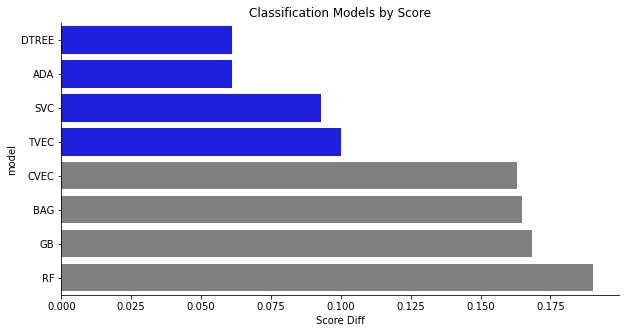

In [43]:
df_overfit = df_overfit.sort_values(by="Score Diff")

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.barplot(data=df_overfit, y='model',x='Score Diff', ax=ax, orient = "h", palette=["blue","blue","blue","blue","gray","gray","gray","gray"]);

plt.title("Classification Models by Score", )
#plt.xlim(0,0.4)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 


*** DTREE, ADA, SVC, TVEC has below 10% difference from their Train Score, while the rest have more than 15%***


# How do we choose our model then? What metrics should we consider to make the decision?


In [44]:
metrics = ['test_score', 'sensitivity', 'f1_score']

to_df = []

for model in models:
    if model in ('BAG', 'TVEC'):
        for metric in metrics:

            dic = {"model": model,
                          "metric": metric,
                          "value": models[model]['gridsearch'][metric]
                         }
            to_df.append(dic)
df_model = pd.DataFrame(to_df)
df_model

,model,metric,value
0,TVEC,test_score,0.821689
1,TVEC,sensitivity,0.893750
2,TVEC,f1_score,0.833819
3,BAG,test_score,0.823775
4,BAG,sensitivity,0.818750
5,BAG,f1_score,0.823037


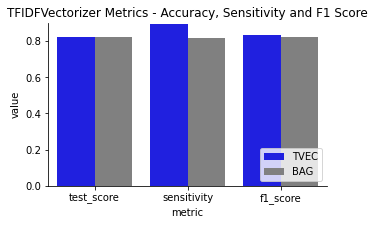

In [45]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.barplot(data=df_model, x='metric', y='value', hue='model', ax=ax, palette=["blue", "gray"]);

plt.title("TFIDFVectorizer Metrics - Accuracy, Sensitivity and F1 Score", fontsize=12)
plt.ylim(0,0.9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.legend(loc='lower right');

In [46]:
metrics = ['specificity', 'precision']

to_df = []

for model in models:
    if model in ('BAG', 'TVEC'):
        for metric in metrics:

            dic = {"model": model,
                          "metric": metric,
                          "value": models[model]['gridsearch'][metric]
                         }
            to_df.append(dic)
df_model = pd.DataFrame(to_df)
df_model

,model,metric,value
0,TVEC,specificity,0.749478
1,TVEC,precision,0.781421
2,BAG,specificity,0.828810
3,BAG,precision,0.827368


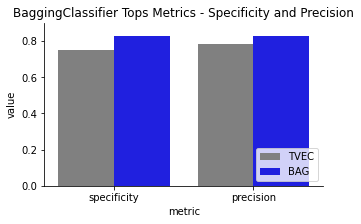

In [47]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sns.barplot(data=df_model, x='metric', y='value', hue='model', ax=ax, palette=["gray", "blue"]);

plt.title("BaggingClassifier Tops Metrics - Specificity and Precision", fontsize=12)
plt.ylim(0,0.9)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.legend(loc='lower right');

***Accuracy***
- TFIDFVectorizer, Bagging Classifier at around 81-82%

***Sensitivity***
- TFIDFVectorizer: 89% of Nutrition are predicted accurately (Positive Class)

***Specificity***
- BaggingClassifier: 82% of Keto post are predicted accurately as Keto (Negative Class)
TFIDFVectorizer 

***Precision***
- BaggingClassifier: 83% 

***F1 Score*** Balance between Sensitivity and Specificity
- TFIDFVectorizer: 83%

# MODEL SELECTION:

For our classification project, we want to have a balance of the correctness in both  subreddits, and ***TFIDF Vectorizer*** tops 3/5 metrics including Accuracy, Sensitivity and F1 Score.

I therefore conclude ***TFIDF Vectorizer*** is the best model, not just for the metrics but also in interpretability, where we can further analyse the coefficients and probability of each class. Though there is overfitting, it is still not as bad as other models.


### AUC-ROC Curve

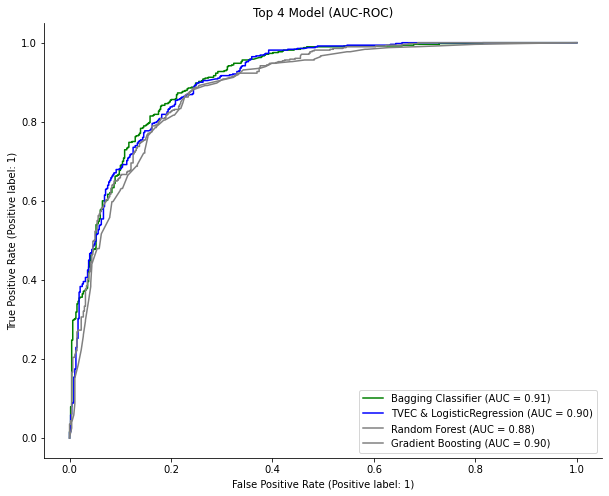

In [48]:
#Visualize ROC
fig, ax = plt.subplots(1, 1, figsize=(10,8))

plot_roc_curve(models["BAG"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='Bagging Classifier', color='green');
plot_roc_curve(models["TVEC"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='TVEC & LogisticRegression', color='blue');
plot_roc_curve(models["RF"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='Random Forest', color='gray');
plot_roc_curve(models["GB"]["gridsearch"]["model"], X_test, y_test,  ax=ax, name='Gradient Boosting', color='gray');

plt.title('Top 4 Model (AUC-ROC)')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 



## POST MODEL ANALYSIS

### Distribution of True Value (Y value) and the Prediction (probability)

In [49]:
bg = models["BAG"]["gridsearch"]["model"]

In [50]:
pred_bg = pd.DataFrame({'true_values': y_test,
                        'pred_probs': bg.predict_proba(X_test)[:,1]})

pred_bg.head()

,true_values,pred_probs
642,0,0.415310
2015,1,0.573416
1725,0,0.335987
1885,0,0.404536
3639,1,0.591529


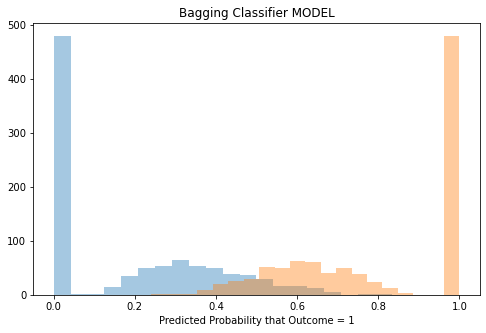

In [51]:
plt.figure(figsize = (8, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_bg.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.title("Bagging Classifier MODEL")
plt.xlabel('Predicted Probability that Outcome = 1');

In [52]:
tvec = models["TVEC"]["gridsearch"]["model"]

In [53]:
pred_tv = pd.DataFrame({'true_values': y_test,
                        'pred_probs': tvec.predict_proba(X_test)[:,1]})

pred_tv.head()

,true_values,pred_probs
642,0,0.465667
2015,1,0.649754
1725,0,0.279710
1885,0,0.433879
3639,1,0.718047


Text(0.5, 1.0, 'TFIDF Vectorizer MODEL')

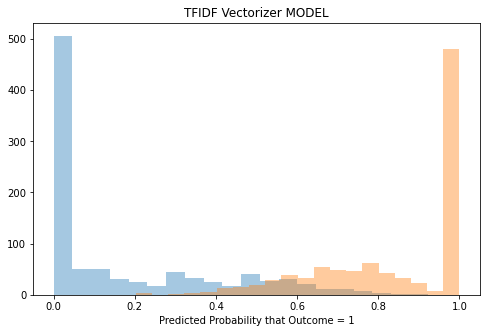

In [54]:
plt.figure(figsize = (8, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_tv.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title("TFIDF Vectorizer MODEL")


### Deep dive in misclassified posts

In [55]:
#let's build a dataframe to look closer of our original data including the model's prediction
predictions = pd.DataFrame(tvec.predict_proba(X))
predictions.rename(columns={0: 'Keto', 1: 'Nutrition'}, inplace=True)
predictions['title'] = df_subr['title']

#our actual label
predictions['actual'] = df_subr['is_nutrition']

#the model's prediction
predictions['predict'] = tvec.predict(X)


In [56]:
#get all misclassified post
misclass_preds = predictions[ (predictions['actual']!= predictions['predict']) ]
misclass_preds.shape

(396, 5)

In [57]:
misclass_preds.head()

,Keto,Nutrition,title,actual,predict
0,0.483562,0.516438,Are the bhb supplement pills worth getting or are they bs?,0,1
4,0.389541,0.610459,Tomorrow is the big day,0,1
6,0.470244,0.529756,Need help with good,0,1
10,0.462222,0.537778,making 2022 my bitch lol,0,1
23,0.404006,0.595994,Cooking for others,0,1


####  False Negative -- posted in "Nutrition" but model wrongly predicted as "Keto"

In [58]:
#let's got some samples with over 80% probability
false_neg = misclass_preds[(misclass_preds['Keto'] > 0.80) & (misclass_preds['actual'] == 1)]

false_neg['actual'] = false_neg['actual'].map(lambda x: 'Nutrition' if x==1 else 'Keto')
false_neg['predict'] = false_neg['predict'].map(lambda x: 'Nutrition' if x==1 else 'Keto')

false_neg

,Keto,Nutrition,title,actual,predict
2492,0.848798,0.151202,FREE KETO COOKBOOK,Nutrition,Keto
2915,0.885272,0.114728,Do keto diet work?,Nutrition,Keto
3031,0.814410,0.185590,Best Keto Plan recipes,Nutrition,Keto


***I could understand the wrong prediction, the "keto" is all over the title, and probably the reason it was predicted as negative class***

####  False Positives -- posted in "Nutrition" but model wrongly predicted as "Keto"

In [59]:
#lets get some sample data
false_pos = misclass_preds[(misclass_preds['Nutrition'] > 0.80) & (misclass_preds['actual'] == 0)]

false_pos['actual'] = false_pos['actual'].map(lambda x: 'Nutrition' if x==1 else 'Keto')
false_pos['predict'] = false_pos['predict'].map(lambda x: 'Nutrition' if x==1 else 'Keto')

false_pos

,Keto,Nutrition,title,actual,predict
301,0.115445,0.884555,Vitamin c,Keto,Nutrition
368,0.177438,0.822562,Protein powders?,Keto,Nutrition
418,0.140506,0.859494,Inaccurate nutrition facts,Keto,Nutrition
684,0.076235,0.923765,Great Value chia seeds nutritional info vs other sources of nutritional info,Keto,Nutrition
685,0.135831,0.864169,"For the purpose of blood sugar/insulin regulation, how important is it to eat protein paired with fat/fiber?",Keto,Nutrition
1266,0.184755,0.815245,"Floralite is a dietary supplement containing units of pure, alive and active microbes designed to nourish your gut, making you lose fat incredibly fast.",Keto,Nutrition
1366,0.160747,0.839253,Wicked Protein,Keto,Nutrition
1614,0.197915,0.802085,eat healthy,Keto,Nutrition
1695,0.170293,0.829707,Vitamin Supplements,Keto,Nutrition


#### 'Nutrients, Vitamins, Protein' are key words for Nutrition, so they are predicted as Nutrition though they posted under Keto subreddits

### Coef_

Bagging doesn't have coef so we will use TVEC. This is one of the trade-off for using more complex models, the interpretability.

In [60]:
#we will use the model for the TFIDFVecotizer to get the coefficients related to Nutrition and Keto
coef = pd.DataFrame(models["TVEC"]["gridsearch"]["model"].best_estimator_.steps[1][1].coef_).T
coef.columns = ['coef']
coef['ngram'] = models["TVEC"]["gridsearch"]["model"].best_estimator_.steps[0][1].get_feature_names()
coef = coef[['ngram','coef']]
coef = coef.sort_values('coef', ascending=False)

In [61]:
top_nutrition_coef = coef.head(15).reset_index(drop=True)
top_keto_coef = coef.tail(15).sort_values(by='coef', ascending=False).reset_index(drop=True)

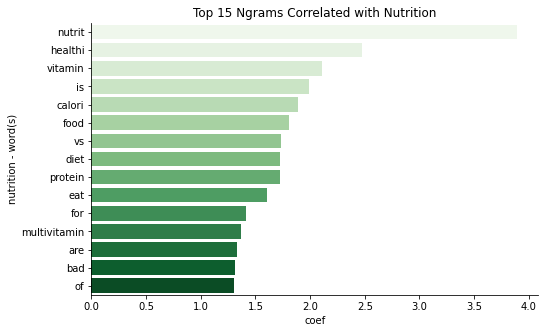

In [62]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.barplot(data=top_nutrition_coef, x='coef', y='ngram', palette='Greens', ax=ax);

ax.set_title("Top 15 Ngrams Correlated with Nutrition", fontsize =12)
ax.set_ylabel('nutrition - word(s)',fontsize=10)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.show()

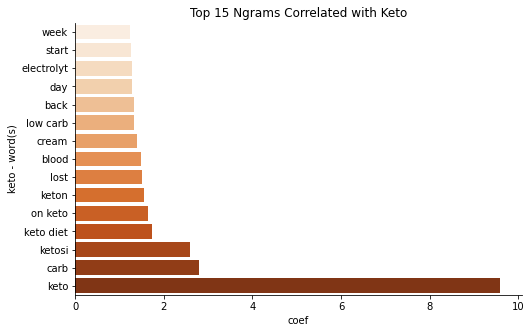

In [63]:

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.barplot(data=top_keto_coef, x=abs(top_keto_coef['coef']), y='ngram', palette='Oranges', ax=ax);

ax.set_title("Top 15 Ngrams Correlated with Keto", fontsize =12)
ax.set_ylabel('keto - word(s)',fontsize=10)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 

plt.show()

# Summary:

***To answer our Business Problem: Yes, we have created models and selected the best model that can classify posts from two different subreddits based on their title with 82% Accuracy.***
     
- We selected ***TFIDF Vecotirizer*** as our best model amongst all models for this classification project, as it is highest not just in Accuracy but also in F1-Score, as we want to balance Sensitivity and Specificity. It is also fast  and easy to build with consistent result compared to ensemble methods like Bagging where data is randomly selected. In terms of interpretability, we can also look at the coefficients to validate the words that have highest correlation to wach subreddits. 
     
## CHALLENGES
- We have observed overfitting in most of the models. This limitation was not overcome by ensemble methods and probably need more tuning on the hyperparameters to achieve better results.

- Time to run GridSearch using hyperparameters.  Boosting is slowest amongst all models, as it builds the model sequentially instead of parallel as Random Forest and Bagging, so tuning the hyperparameters can take longer time, 10 minutes if you minimize your hyperparameters, but can take hours if you add more depth.
    
    
    

# Recommendation:
  - Tuning of hyperparameters to overcome overfitting
  - Include other features like self-text and probably sentiment analysis score might improve our metrics.
  - Include images or videos in our anaysis for more accurate prediction (which requires more knowledge on different ML domains)